In [38]:
import zipfile, os

zip_path = "dataset.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted folders:", os.listdir(extract_path))



Extracted folders: ['manuscript']


In [39]:
extract_path = "/content/dataset/manuscript"


In [40]:
import os

print("Sanskrit images:", len(os.listdir("/content/dataset/manuscript/sanskrit")))
print("Tamil images:", len(os.listdir("/content/dataset/manuscript/tamil")))


Sanskrit images: 97
Tamil images: 100


In [41]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


In [42]:
DATASET_PATH = "/content/dataset/manuscript"
CATEGORIES = ["sanskrit", "tamil"]
IMG_SIZE = 64


In [43]:
data = []
labels = []

for label, category in enumerate(CATEGORIES):
    folder_path = os.path.join(DATASET_PATH, category)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0
            data.append(img)
            labels.append(label)
        except:
            print("Skipped:", img_path)

X = np.array(data).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(labels)

print("Total images loaded:", len(X))


Total images loaded: 197


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 157
Testing samples: 40


In [45]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1
)

datagen.fit(X_train)


In [46]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 821,761 (3.13 MB)

 Trainable params: 821,761 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_test, y_test),
    epochs=15,
    callbacks=[early_stop]
)


Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5484 - loss: 0.7140 - val_accuracy: 0.5250 - val_loss: 0.7333
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.6057 - loss: 0.6494 - val_accuracy: 0.7000 - val_loss: 0.6911
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.8441 - loss: 0.4687 - val_accuracy: 0.7500 - val_loss: 0.7826
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8288 - loss: 0.4441 - val_accuracy: 0.7500 - val_loss: 0.8650
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.8120 - loss: 0.4378 - val_accuracy: 0.7500 - val_loss: 0.5836
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.8907 - loss: 0.2972 - val_accuracy: 0.8000 - val_loss: 0.4778
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9402 - loss: 0.2505 - val_accuracy: 0.8000 - val_loss: 0.4265
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9379 - loss: 0.1649 - val_accuracy: 0.8250 - val_loss:

In [48]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Final Test Accuracy:", round(test_acc * 100, 2), "%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9458 - loss: 0.1551
Final Test Accuracy: 95.0 %


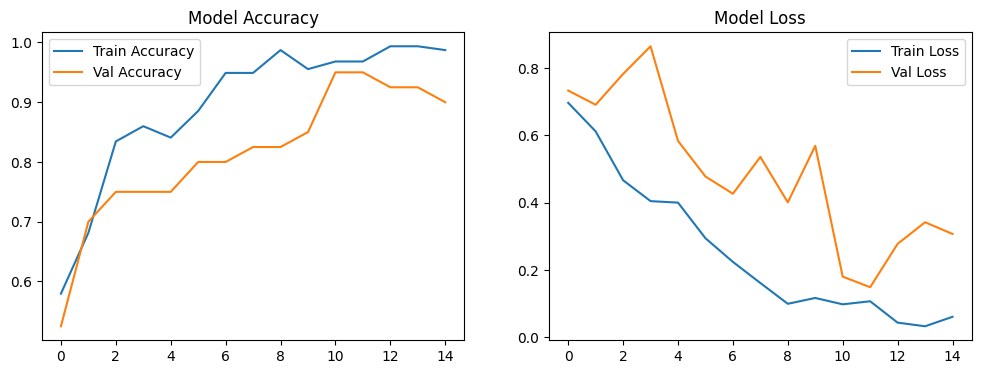

In [49]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Loss")

plt.show()


In [50]:
import os

print(os.listdir("/content/dataset/manuscript/sanskrit"))



['book1_page-0007_word_70.png', 'book1_page-0009_word_93.png', 'book1_page-0007_word_68.png', 'book1_page-0007_word_76.png', 'book1_page-0009_word_92.png', 'book1_page-0007_word_67.png', 'book1_page-0007_word_61.png', 'book1_page-0003_word_20.png', 'book1_page-0005_word_45.png', 'book1_page-0004_word_37.png', 'book1_page-0004_word_23.png', 'book1_page-0009_word_80.png', 'book1_page-0005_word_41.png', 'book1_page-0005_word_39.png', 'book1_page-0005_word_44.png', 'book1_page-0009_word_86.png', 'book1_page-0001_word_1.png', 'book1_page-0001_word_3.png', 'book1_page-0001_word_11.png', 'book1_page-0007_word_73.png', 'book1_page-0009_word_90.png', 'book1_page-0005_word_46.png', 'book1_page-0004_word_35.png', 'book1_page-0001_word_18.png', 'book1_page-0001_word_2.png', 'book1_page-0005_word_54.png', 'book1_page-0005_word_43.png', 'book1_page-0004_word_25.png', 'book1_page-0009_word_82.png', 'book1_page-0004_word_29.png', 'book1_page-0009_word_95.png', 'book1_page-0007_word_62.png', 'book1_pag

In [51]:
import cv2
import matplotlib.pyplot as plt

# ---- Correct single-character image paths ----
sanskrit_path = "/content/dataset/manuscript/sanskrit/book1_page-0001_word_12.png"
tamil_path    = "/content/dataset/manuscript/tamil/tamil1_page-0001_word_33.png"


In [52]:

def load_and_prepare(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found: {path}")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_norm = img / 255.0
    return img, img_norm

def recognize(img_norm):
    img_norm = img_norm.reshape(1, IMG_SIZE, IMG_SIZE, 1)
    pred = model.predict(img_norm, verbose=0)[0][0]
    return "Sanskrit" if pred < 0.5 else "Tamil"

san_img, san_norm = load_and_prepare(sanskrit_path)
tam_img, tam_norm = load_and_prepare(tamil_path)

# ---- Recognition ----
san_label = recognize(san_norm)
tam_label = recognize(tam_norm)

# ---- Reconstruction ----
san_recon = reconstruct_image(san_norm)
tam_recon = reconstruct_image(tam_norm)

# ---- Display layout ----
plt.figure(figsize=(8,8))

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

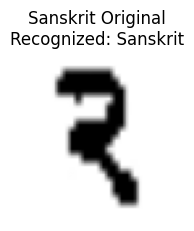

In [53]:
plt.subplot(2,2,1)
plt.imshow(san_img, cmap='gray')
plt.title(f"Sanskrit Original\nRecognized: {san_label}")
plt.axis('off')

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

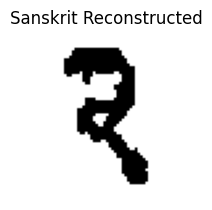

In [54]:
plt.subplot(2,2,2)
plt.imshow(san_recon, cmap='gray')
plt.title("Sanskrit Reconstructed")
plt.axis('off')

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

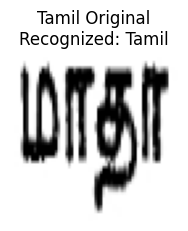

In [55]:
plt.subplot(2,2,3)
plt.imshow(tam_img, cmap='gray')
plt.title(f"Tamil Original\nRecognized: {tam_label}")
plt.axis('off')


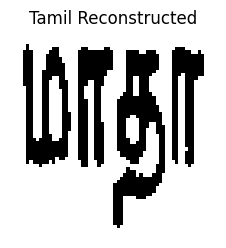

In [56]:
plt.subplot(2,2,4)
plt.imshow(tam_recon, cmap='gray')
plt.title("Tamil Reconstructed")
plt.axis('off')

plt.tight_layout()
plt.show()


In [57]:
from sklearn.metrics import mean_squared_error

# ---- Sanskrit MSE ----
mse_sanskrit = mean_squared_error(
    san_img.flatten(),
    san_recon.flatten()
)
# ---- Tamil MSE ----
mse_tamil = mean_squared_error(
    tam_img.flatten(),
    tam_recon.flatten()
)

print("Reconstruction MSE (Sanskrit):", mse_sanskrit)
print("Reconstruction MSE (Tamil):", mse_tamil)


Reconstruction MSE (Sanskrit): 1140.2509765625
Reconstruction MSE (Tamil): 1580.89404296875
